 # <font color = #254117>[EEP 147]: ESG Capacity Expansion Notebook</font>

 <div style="width:image width px; font-size:80%; text-align:center;"><img src="Maverick-1.jpg" alt="alternate text" width="500" height="height" style="padding-bottom:0.5em;" />
<br>173 MW Maverick 1 Solar Project - Southern California Edison</div>

<br>
<font color = "red">Version 2025.4</font>

# Navigating this notebook

- Open the table of contents: View > Left Sidebar > Show Table of Contents.
- You can click Run > Run All Cells, then scroll to section 7 to test different capacity expansion scenarios. 
- You can collapse all cells by clicking View > Collapse All Code. We suggest you start by looking at the notebook this way and expanding the sections as necessary.

# Introduction
This notebook can be utilized for exploring capacity expansion in the Electricity Strategy Game. The goal is to choose which generating plants to keep/retire, and which new plants to build to meet demand at the lowest cost while also achieving our emissions goals. If you want to start running scenarios immediately, run the whole notebook and skip to section 7. 

Sections 1-6 contain the python code needed to setup the electricity market simulation.

# 1. Import packages we use
First on our agenda is to import **<font color = ##008700>dependencies</font>** -- packages in Python that add to the basic functions in Python.

In [1]:
from datascience import *
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import numpy as np
import pandas as pd
from ipywidgets import interact, interactive, Dropdown, IntSlider, BoundedFloatText, HTML, GridspecLayout
import ipywidgets as widgets
from functools import partial
from IPython.display import display
from typing import List, Dict, Union
import pickle

plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [10,6]
# Show all columns and rows of pandas DataFrames
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
# warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# 2. Global Variables
Variables in `ALL_CAPS` are global variables that are defined in earlier sections of the notebook so they can be used later. For example, `DEMAND` is defined in the next section and is the dataframe that contains the hour-level demand forecast for each season; this will be used to run the simulations in section 7.


In [2]:
DISCOUNT_RATE = 0.02  # for annualizing the capital expenditures
TIME_HORIZON = 30  # years

# 3. Load demand, supply, bids, and portfolio information
Next we load the files for forecasted demand, old ESG profiles, and new generator characteristics into pandas dataframes.

**Demand:** 
- For each season in 2024, we load a CSV of a typical day's hourly demand.
- This will help us represent the differences in hourly demand during different seasons.

**Supply:**
- For each season in 2024, we load a CSV of a typical day's supply from different types of plants.
- This will help us represent the differences in hourly supply between different plant types (e.g., solar vs coal).

## 3.1 Calculate representative seasonal demand profiles
You can skip this if you like -- the code below just takes 5-min demand and aggregates it to 1-hour demand profiles for each season.

- We want a representative seasonal demand profile to use for examining the effects of various capacity expansion scenarios.
- We need to make sure we can match demand in all hours when we plan new capacity.
- We will use real 5-min demand data from CAISO on a typical day during each season.
- To match our ESG simulation, we need to aggregate each day's data to the hourly level.
- We also need to scale down the CAISO demand data to match the average ESG hourly demand because the ESG is based on demand in the '90s.
- The seasonal demand profiles are meant to show you the shape of the hourly demand (when demand peaks).
- It would be more realistic to use the raw CAISO demand for designing capacity expansion, but we leave that for an extra curricular activity.

In [3]:
# Load the original ESG demand
esg_demand = pd.read_csv('demand_data/demand_proj.csv')
# Calculate the average demand for scaling the CAISO demand
esg_avg_demand = esg_demand['load'].mean()

# Check if the seasonal file already exists
seasonal_demand_fp = Path('demand_CapacityExpansion.csv')
# If the file does not exist yet, create it by aggregating the 5-min demand data
if not seasonal_demand_fp.exists():
    print('Creating seasonal demand file from raw CAISO demand files')

    # Load each of the CAISO demand files
    month_to_season_lookup = {'Winter': [12, 1, 2], 'Spring': [3, 4, 5], 'Summer': [6, 7, 8], 'Fall': [9, 10, 11]}
    dfs = []
    for csv in Path('demand_data').glob('CAISO-demand*.csv'):
        df = pd.read_csv(csv)
        # Set the first column with row headers to index before transposing the table so they become column headers
        df = df.set_index(df.columns[0])
        # Transpose to get a column of demand
        df = df.transpose()
        # Reset index to get the time column back in the main dataframe
        df = df.reset_index(names='time')
        # Rename the existing index column
        df.columns.name = ''
        df = df.rename(columns={'Demand': 'demand'})
        # get the month from the file name like "CAISO-demand-20240214.csv"
        file_ending = csv.stem.split('-')[-1]
        month = int(file_ending[4:6])
        # Add the season to the dataframe
        df['season'] = [season for season, months in month_to_season_lookup.items() if month in months][0]
        # Keep only needed columns
        dfs.append(df[['season', 'time', 'demand']])


    # Put all the demand files into a single dataframe with season, time, and demand columns
    df = pd.concat(dfs) 

    # Aggreagte the demand to the season-hour
    df['hour'] = df['time'].apply(lambda x: int(x.split(':')[0]))
    df = df.groupby(['season', 'hour']).agg({'demand': 'mean'}).reset_index()

    # Calculate mean of CAISO demand and scale to match ESG mean demand
    caiso_avg_demand = df['demand'].mean()
    scaling_factor = esg_avg_demand / caiso_avg_demand
    df['demand'] = df['demand'] * scaling_factor

    # Save the aggregated demand to a file
    df.to_csv(seasonal_demand_fp, index=False)

# Load the seasonal demand file
DEMAND = pd.read_csv(seasonal_demand_fp)

# Save the number of hours in each day
N_HOURS_PER_DAY = DEMAND.hour.nunique()

## 3.2 Plot the seasonal demand curves
We can see below that Summer demand is significantly different from other seasons. We will need to account for this when deciding which plants to retire and which new plants to build.

In [4]:
def plot_seasonal_demand():
    fig, ax = plt.subplots()
    for season in DEMAND.season.unique():
        DEMAND[DEMAND.season == season].plot(x='hour', y='demand', ax=ax, label=season)
    plt.title('Seasonal Demand Profiles')
    plt.xlabel('Hour of the day')
    plt.ylabel('Demand (MW)')
    # X min 0
    plt.xlim(0, 23)
    # x ticks every 4 hours
    plt.xticks(np.arange(0, 24, 4))
    plt.show()

# plot_seasonal_demand()

## 3.3 Calculate representative seasonal supply profiles

In [5]:
# Set the new plant size
NEW_PLANT_CAPACITY = 100 # MW

# Check if the seasonal file already exists
seasonal_supply_fp = Path('supply_CapacityExpansion.csv')
# If the file does not exist yet, create it by aggregating the 5-min demand data
if not seasonal_supply_fp.exists():
    print('Creating seasonal supply file from raw CAISO supply files')

    # Load each of the CAISO demand files
    month_to_season_lookup = {'Winter': [12, 1, 2], 'Spring': [3, 4, 5], 'Summer': [6, 7, 8], 'Fall': [9, 10, 11]}
    dfs = []
    for csv in Path('supply_data').glob('CAISO-renewables*.csv'):
        df = pd.read_csv(csv)
        # Set the first column with row headers to index before transposing the table so they become column headers
        df = df.set_index(df.columns[0])
        # Transpose to get a column of demand
        df = df.transpose()
        # Reset index to get the time column back in the main dataframe
        df = df.reset_index(names='time')
        # Rename the existing index column
        df.columns.name = ''
        df = df.rename(columns={'Solar': 'solar_supply', 'Wind': 'wind_supply'})
        # get the month from the file name like "CAISO-renewables-20240214.csv"
        file_ending = csv.stem.split('-')[-1]
        month = int(file_ending[4:6])
        # Add the season to the dataframe
        df['season'] = [season for season, months in month_to_season_lookup.items() if month in months][0]
        # Keep only needed columns
        dfs.append(df[['season', 'time', 'solar_supply', 'wind_supply']])


    # Put all the demand files into a single dataframe with season, time, and demand columns
    df = pd.concat(dfs) 

    # Aggreagte the demand to the season-hour
    df['hour'] = df['time'].apply(lambda x: int(x.split(':')[0]))
    df = df.groupby(['season', 'hour']).agg({'solar_supply': 'mean', 'wind_supply': 'mean'}).reset_index()

    # Calculate max of CAISO supply for solar/wind and scale to match new plant size (100MW)
    max_supplies = df[['solar_supply', 'wind_supply']].max()  # 1x2
    scaling_factors = NEW_PLANT_CAPACITY / max_supplies  #1x2
    df[['solar_supply', 'wind_supply']] = df[['solar_supply', 'wind_supply']] * scaling_factors

    # Save the aggregated demand to a file
    df.to_csv(seasonal_supply_fp, index=False)

# Load the seasonal demand file
SUPPLY = pd.read_csv(seasonal_supply_fp)
SUPPLY.head()

,season,hour,solar_supply,wind_supply
0,Fall,0,-0.131023,21.548817
1,Fall,1,-0.131896,21.206194
2,Fall,2,-0.131023,20.792079
3,Fall,3,-0.131459,20.591092
4,Fall,4,-0.132333,20.515553


## 3.4 Plot the seasonal supply curves

In [6]:
def plot_seasonal_supply():
    fig, axes = plt.subplots(1,2, figsize=(20, 6))
    for i, tech in enumerate(['solar', 'wind']):
        ax = axes[i]
        for season in SUPPLY.season.unique():
            SUPPLY[SUPPLY.season == season].plot(x='hour', y=f'{tech}_supply', ax=ax, label=season)
        ax.set_title(f'Seasonal Supply Profiles for {tech.capitalize()}')
        ax.set_xlabel('Hour of the day')
        ax.set_ylabel('Supply (MW)')
        # X min 0
        ax.set_xlim(0, 23)
        # x ticks every 4 hours
        ax.set_xticks(np.arange(0, 24, 4))
    plt.show()

# plot_seasonal_supply()

## 3.5 Load the generator profiles
- Load the incumbent ESG plant characteristics
- Load the new plant characteristics
- Scale FixedCst_OandM_perHour of new plants so that FixedCst_OandM_perHour_perMW of a new nuclear plant matches that of an old nuclear plant
  - this is to make sure the old and new fixed costs are in the same ballpark, and assumes that nuclear daily operation and maintenance costs do not change much over time
- Use fuel cost directly as variable costs (removing the variable O&M costs). Keep the fixed daily O&M costs.
- Create hourly fixed O&M variable to apply across in all hours for any active generator (even if it's not running that hour)

In [7]:
# Load the generator profiles
OLD_PLANTS = pd.read_excel('ESGPorfolios_CapacityExpansion.xlsx')

# NEW_PROFILES = pd.read_csv('NewGeneratorCharacteristics.csv')
NEW_PLANTS = pd.read_excel('NewGeneratorCharacteristics_CapacityExpansion.xlsx').sort_values('Plant_Type')

In [8]:
# Create Hourly Fixed O&M Variable
OLD_PLANTS['FixedCst_OandM_perHour'] = OLD_PLANTS['FixedCst_OandM_perDay'] / 4  # a "day" in the ESG is one 4-hour round
NEW_PLANTS['FixedCst_OandM_perHour'] = NEW_PLANTS['FixedCst_OandM_perDay'] / 24
# Create Fixed O&M cost per hour per MW to compare old and new nuclear plants
OLD_PLANTS['FixedCst_OandM_perHour_perMW'] = OLD_PLANTS['FixedCst_OandM_perHour'] / OLD_PLANTS['Capacity_MW']
NEW_PLANTS['FixedCst_OandM_perHour_perMW'] = NEW_PLANTS['FixedCst_OandM_perHour'] / NEW_PLANTS['Capacity_MW']

In [9]:
# Scale FixedCst_OandM_perHour
# Get hourly fixed O&M cost (per MW) of old nuclear plant
old_nuclear_fixed_cost = OLD_PLANTS[OLD_PLANTS['Primary_Fuel_Type'] == 'Nuclear']['FixedCst_OandM_perHour_perMW'].iloc[0]

# Get hourly fixed O&M cost (per MW) of new nuclear plant before scaling
new_nuclear_fixed_cost = NEW_PLANTS[NEW_PLANTS['Plant_Type'] == 'Nuclear']['FixedCst_OandM_perHour_perMW'].iloc[0]

# Calculate scaling factor
scaling_factor = old_nuclear_fixed_cost / new_nuclear_fixed_cost

# Scale all new plant fixed costs
NEW_PLANTS['FixedCst_OandM_perHour'] = NEW_PLANTS['FixedCst_OandM_perHour'] * scaling_factor
# Drop FixedCst_OandM_perHour_perMW columns
OLD_PLANTS = OLD_PLANTS.drop('FixedCst_OandM_perHour_perMW', axis=1)
NEW_PLANTS = NEW_PLANTS.drop('FixedCst_OandM_perHour_perMW', axis=1)



In [10]:
# Set variable costs to only fuel costs
OLD_PLANTS['Var_Cost_USDperMWH'] = OLD_PLANTS['Fuel_Cost_USDperMWH']
NEW_PLANTS['Var_Cost_USDperMWH'] = NEW_PLANTS['Fuel_Cost_USDperMWH']

## 3.6 Examine the portfolio of incumbent generating plants
Display the characteristics of incumbent plants (plants that are already in the ESG). Note there are new variables in this table -- the orignal cost variables have been given the `_2000` prefix to denote they are from the year 2000, and the replacement columns updated the costs from 2000 to 2022 using an inflation adjustment factor of 1.69976771196283.

`Var_Cost_USDperMWH` is the marginal cost of producing one additional MWh in 2022 dollars.

In [11]:
OLD_PLANTS[OLD_PLANTS['Group'] == 'Old Timers']

,Group,Group_num,UNIT NAME,Primary_Fuel_Type,Capacity_MW,Heat_Rate_MMBtu_perMWH,Fuel_Cost_USDperMMBtu,Fuel_Cost_USDperMWH_2000,Fuel_Cost_USDperMWH,Var_OandM_USDperMWH_2000,Var_OandM_USDperMWH,Var_Cost_USDperMWH_2000,Var_Cost_USDperMWH,Carbon_tonsperMWH,FixedCst_OandM_perDay_2000,FixedCst_OandM_perDay,Plant_ID,FixedCst_OandM_perHour
32,Old Timers,6,BIG CREEK,Hydroelectric,1000,0.000000,0.00,0.00,0.000000,0.0,0.000000,0.00,0.000000,0.00,15000,25496.515679,61,6374.12892
33,Old Timers,6,MOHAVE 1,Coal,750,10.000000,2.55,30.00,25.500000,4.5,7.648955,34.50,25.500000,0.94,15000,25496.515679,62,6374.12892
34,Old Timers,6,MOHAVE 2,Coal,750,10.000000,2.55,30.00,25.500000,4.5,7.648955,34.50,25.500000,0.94,15000,25496.515679,63,6374.12892
35,Old Timers,6,HIGHGROVE,Natural Gas,150,10.913580,3.03,49.11,33.068148,0.5,0.849884,49.61,33.068148,0.58,0,0.000000,64,0.00000
36,Old Timers,6,SAN BERNADINO,Natural Gas,100,11.876543,3.03,53.44,35.985926,0.5,0.849884,53.94,35.985926,0.63,0,0.000000,65,0.00000


## 3.7 Examine the characteristics of the new generating plants we might build
Display the characteristics of the new plants.

The important columns are:
- `Var_Cost_USDperMWH` = the marginal cost of producing one MWh in 2022 dollars.
- `FixedCst_OandM_perHour` = the fixed cost of operating the plant each hour, regardless of generation. This cost is incurred even if the plant does not run at all.
- `Carbon_tonsperMWH` = the emissions intensity of the plant: tons of C02 per MWh of generation.
- `Capital_Expenditure_perMW` = the capital cost in 2022 of building the plant. Total investment cost  = `Capital_Expenditure_perMW` * `Capacity_MW`.

In [12]:
NEW_PLANTS

,Plant_Type,Capacity_MW,Heat_Rate_MMBtu_perMWH,Fuel_Cost_USDperMMBtu,Fuel_Cost_USDperMWH,Var_OandM_USDperMWH,Var_Cost_USDperMWH,CO2_lbsperMMBtu,Carbon_tonsperMWH,FixedCst_OandM_perkWperYear,FixedCst_OandM_perDay,CapEx_perkW,Construction_Financing_Cst_perkW,Capital_Expenditure_perMW,FixedCst_OandM_perHour
0,Coal,400,8.490,2.55,21.64950,9.30,21.64950,202.3,0.779058,86.500000,94794.520548,4078.56,777.36,4855920,1680.341795
1,Natural Gas,100,9.717,3.03,29.44251,6.94,29.44251,119.0,0.524500,26.100000,7150.684932,1348.82,138.42,1487240,126.754107
2,Nuclear,1000,10.497,0.97,10.18209,2.80,10.18209,0.0,0.000000,175.000000,479452.054795,7616.36,1766.36,9382720,8498.838560
4,Solar,100,0.000,0.00,0.00000,0.00,0.00000,0.0,0.000000,23.765603,6511.124235,1482.68,51.29,1533970,115.417158
3,Wind,100,0.000,0.00,0.00000,0.00,0.00000,0.0,0.000000,32.443047,8888.506101,1665.79,94.23,1760020,157.558983


# 4. Define functions to describe and clear the market

Note: Many of the cells in the rest of the notebook have variables defined as `variable_temp`. These will not influence the final simulation in section 7, but are just used to test each of the functions to see the output. Some of the outputs have been commented out. You can uncomment the lines at the bottom of some cells to show the test output.

## 4.1 Fetch Demand
We want to know how our fleet of generators will do during the typical types of demand we see in each season -- we saw in section 3.2 that Summer demand is different from other months and we will need to account for that when choosing our old and new plants.

We will need to load demand for a given season and hour. Let's create a function that looks up the forecasted demand for a season and hour.

In [13]:
# Show the demand table
DEMAND.head(5)

,season,hour,demand
0,Fall,0,13726.236670
1,Fall,1,13272.507770
2,Fall,2,12899.452202
3,Fall,3,12788.884427
4,Fall,4,13065.590309


In [14]:
def calc_demand(season: str, hour: int, demand_multiplier: float = 1) -> float:
    """
    Calculate the demand for a given season and hour. 
    
    Parameters:
    season: str - the season of the year (Winter, Spring, Summer, Fall)
    hour: int - the hour of the day (0-23)
    
    Returns:
    float - the demand in MW
    """
    demand = DEMAND[(DEMAND.season == season) & (DEMAND.hour == hour)]['demand'].values[0]
    return demand * demand_multiplier

# Test the function to get 12pm demand in Fall
season_temp = 'Fall'
hour_temp = 12
demand_temp = calc_demand(season_temp, hour_temp)
demand_temp

13407.2410877

## 4.2 Merge old plants and new plants
We need to merge the remaining incumbent plants with the new plants to help calculate the price. We need to:
- Take a dictionary that contains the number of new plants to create and return a dataframe of the new plants (with all their characteristics)
- Take a list of the incumbent plants that are still active and return a dataframe of the remaining old plants (with all their characteristics)
- Merge the old and new plant dataframes (used to calculating the market outcomes later)

In [15]:
def get_new_plant_dataframe(new_plants:Dict):
    """Return a dataframe with one row per new plant built.
    
    Parameters:
    new_plants: Dict - a dictionary with plant types as keys and the number of plants built as values
    
    Returns:
    pd.DataFrame - a dataframe with one row per new plant built, copied from NEW_PLANTS
    """    
    # For each of the new plant types, create a row for each plant built
    rows = []
    for plant_type in new_plants.keys():
        for i in range(new_plants[plant_type]):
            row = NEW_PLANTS[NEW_PLANTS['Plant_Type'] == plant_type].iloc[0].copy()
            row["UNIT NAME"] = f"New {plant_type} {i+1}"
            rows.append(row)
    
    df = pd.DataFrame(rows)
    # Move unit name to front of dataframe
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    # Rename plant type column to match the old plant dataframe
    df = df.rename(columns={'Plant_Type': 'Primary_Fuel_Type'})
    return df

# Test the function with a few new plants
new_plants_temp = {'Natural Gas': 2, 'Solar': 1, 'Wind': 1}
get_new_plant_dataframe(new_plants_temp)

,UNIT NAME,Primary_Fuel_Type,Capacity_MW,Heat_Rate_MMBtu_perMWH,Fuel_Cost_USDperMMBtu,Fuel_Cost_USDperMWH,Var_OandM_USDperMWH,Var_Cost_USDperMWH,CO2_lbsperMMBtu,Carbon_tonsperMWH,FixedCst_OandM_perkWperYear,FixedCst_OandM_perDay,CapEx_perkW,Construction_Financing_Cst_perkW,Capital_Expenditure_perMW,FixedCst_OandM_perHour
1,New Natural Gas 1,Natural Gas,100,9.717,3.03,29.44251,6.94,29.44251,119.0,0.5245,26.100000,7150.684932,1348.82,138.42,1487240,126.754107
1,New Natural Gas 2,Natural Gas,100,9.717,3.03,29.44251,6.94,29.44251,119.0,0.5245,26.100000,7150.684932,1348.82,138.42,1487240,126.754107
4,New Solar 1,Solar,100,0.000,0.00,0.00000,0.00,0.00000,0.0,0.0000,23.765603,6511.124235,1482.68,51.29,1533970,115.417158
3,New Wind 1,Wind,100,0.000,0.00,0.00000,0.00,0.00000,0.0,0.0000,32.443047,8888.506101,1665.79,94.23,1760020,157.558983


In [16]:
def get_fleet_portfolio(active_plants: List, new_plants: Dict):
    """
    Get the fleet portfolio of active and new plants.

    Parameters:
    active_plants: List - the list of active plants' names
    new_plants: Dict - the dictionary of new plants' types and capacities

    Returns:
    pd.DataFrame - the fleet portfolio
    """
    # Filter to active incumbent plants
    old = OLD_PLANTS[OLD_PLANTS["UNIT NAME"].isin(active_plants)]

    # Create a dataframe for the new plants
    new = get_new_plant_dataframe(new_plants)

    # Combine the active and new plants
    cols = ["UNIT NAME", "Primary_Fuel_Type", "Capacity_MW", "Var_Cost_USDperMWH", "Carbon_tonsperMWH", "FixedCst_OandM_perHour"]
    if new.empty:
        df = old[cols].copy()
    else:
        df = pd.concat([old[cols], new[cols]])
    return df

# Test the function with a few new plants and most of the old plants
active_plants = OLD_PLANTS["UNIT NAME"].tolist()[:-2]
fleet_temp = get_fleet_portfolio(active_plants, new_plants_temp)
fleet_temp

,UNIT NAME,Primary_Fuel_Type,Capacity_MW,Var_Cost_USDperMWH,Carbon_tonsperMWH,FixedCst_OandM_perHour
0,FOUR CORNERS,Coal,1900,29.750000,1.1000,3399.535424
1,ALAMITOS 7,Natural Gas,250,48.629630,0.8500,0.000000
2,HUNTINGTON BEACH 1&2,Natural Gas,300,26.260000,0.4600,849.883856
3,HUNTINGTON BEACH 5,Natural Gas,150,43.766667,0.7700,849.883856
4,REDONDO 5&6,Natural Gas,350,27.232593,0.4800,1274.825784
5,REDONDO 7&8,Natural Gas,950,27.232593,0.4800,2124.709640
6,EL SEGUNDO 1&2,Natural Gas,400,29.177778,0.5100,424.941928
7,EL SEGUNDO 3&4,Natural Gas,650,26.746296,0.4700,424.941928
8,LONG BEACH,Natural Gas,550,35.013333,0.6100,849.883856
9,NORTH ISLAND,Natural Gas,150,43.766667,0.7700,0.000000


## 4.3 Generate marginal cost bids
For the capacity expansion exercise, we will assume all plants are bidding their marginal cost. Below we create a dataframe of the incumbent and new plants with a marginal cost bidding column `price`. This will be used as the bidding dataframe to calculate the market clearing price. If you were interested in adding in alternative bids (above marginal cost), you will need to create your own `bids` dataframe to put into the `price_calc` function.

In [17]:
def add_marginal_cost_bids(fleet: pd.DataFrame, season: str, hour: int, carbon_price: float = 0) -> pd.DataFrame:
    """
    Calculate the marginal cost bids for each plant in the fleet.

    Parameters:
    fleet: pd.DataFrame - the current fleet portfolio (active and new plants)
    season: str - the season of the year (Winter, Spring, Summer, Fall)
    hour: int - the hour of the day (0-23)
    carbon_price: float - the price of carbon emissions in USD/short ton

    Returns:
    pd.DataFrame - the fleet portfolio with marginal cost bids
    """
    cols =['UNIT NAME', 'Primary_Fuel_Type', 'season', 'hour', 'Capacity_MW', 'Var_Cost_USDperMWH', 'FixedCst_OandM_perHour', 'Carbon_tonsperMWH', 'price']
    df = fleet.copy()
    df['season'] = season
    df['hour'] = hour
    df['price'] = df['Var_Cost_USDperMWH'] + df['Carbon_tonsperMWH'] * carbon_price
    df.sort_values(by='price', inplace=True)
    return df[cols]

# Test the function with 2 active plants and 4 new plants
bids_temp = add_marginal_cost_bids(fleet=fleet_temp, season=season_temp, hour=hour_temp)
bids_temp

,UNIT NAME,Primary_Fuel_Type,season,hour,Capacity_MW,Var_Cost_USDperMWH,FixedCst_OandM_perHour,Carbon_tonsperMWH,price
3,New Wind 1,Wind,Fall,12,100,0.000000,157.558983,0.0000,0.000000
4,New Solar 1,Solar,Fall,12,100,0.000000,115.417158,0.0000,0.000000
32,BIG CREEK,Hydroelectric,Fall,12,1000,0.000000,6374.128920,0.0000,0.000000
38,HELMS,Hydroelectric,Fall,12,800,0.000000,6374.128920,0.0000,0.000000
16,MOSS LANDING 7,Natural Gas,Fall,12,750,20.910741,3399.535424,0.3700,20.910741
15,MOSS LANDING 6,Natural Gas,Fall,12,750,20.910741,3399.535424,0.3700,20.910741
27,PITTSBURGH 5&6,Natural Gas,Fall,12,650,24.314815,1062.354820,0.4300,24.314815
14,MORRO BAY 3&4,Natural Gas,Fall,12,665,24.314815,1699.767712,0.4300,24.314815
24,ORMOND BEACH 1,Natural Gas,Fall,12,700,25.287407,2974.593496,0.4400,25.287407
22,MANDALAY 1&2,Natural Gas,Fall,12,300,25.287407,424.941928,0.4400,25.287407


## 4.4 Update Renewable Capacities by season and hour of day

### Scale new plant supply capacity by hour of day
- Solar and Wind are intermittent sources of power, which means they don't produce a constant amount of power for the grid.
- When you build a solar/wind plant, you build a plant-wide **nameplate capacity** for the plant (the total amount of power generating capacity the plant can supply in ideal sun/wind conditions).
- In the ESG, we define each plant to have a plant-wide nameplate capacity of 100 MW. 
- We will scale that capacity by the hourly supply profile of the plant to get the actual supply at each hour of the day.

Example:
- A solar plant has a maximum supply at 1pm (when the sun is hitting it at the best angle).
- At 8am, the plant is producing roughly 60% of what it produces at 1pm.
- If we need to know the supply at 8am, and we built a 100 MW plant, we will assume the plant can generate (100MW)*(80%) = 80MW at 8am.



In [18]:
def calc_renewable_supply(season: str, hour: int, tech: str) -> float:
    """
    Calculate the supply for a given season and hour for a plant of a given technology. 
    
    Parameters:
    season: str - the season of the year (Winter, Spring, Summer, Fall)
    hour: int - the hour of the day (0-23)
    tech: str - the technology of the plant (solar, wind)
    
    Returns:
    float - the supply in MW
    """
    hour_specific_capacity = SUPPLY[(SUPPLY.season == season) & (SUPPLY.hour == hour)][f'{tech.lower()}_supply'].values[0]
    return hour_specific_capacity

# Test the function to get 3am demand in Fall
supply_temp = calc_renewable_supply(season_temp, hour_temp, 'solar')
supply_temp  #MW

79.314139967200006

### Update Renewable Capacity for the hour
We need a function to update a bids dataframe with corrected renewable capacities. Note that a bids dataframe will be for a specific season and hour.

In [19]:
def update_renewable_capacity(df, season, hour):
    """
    Update the capacity of the renewable plants for a given season and hour.
    
    Parameters:
    df: pd.DataFrame - the dataframe containing the plant information
    season: str - the season of the year (Winter, Spring, Summer, Fall)
    hour: int - the hour of the day (0-23)
    
    Returns:
    pd.DataFrame - the updated dataframe with the new capacity values
    """
    for tech in ['solar', 'wind']:
        tech_filter = df['Primary_Fuel_Type'] == tech.capitalize()
        supply = calc_renewable_supply(season, hour, tech)
        df.loc[tech_filter, 'Capacity_MW'] = supply
    return df

# Test the function with to update renewable capacity for 10am in Fall
bids_temp_updated = update_renewable_capacity(df=bids_temp, season=season_temp, hour=hour_temp)
bids_temp_updated.head()

,UNIT NAME,Primary_Fuel_Type,season,hour,Capacity_MW,Var_Cost_USDperMWH,FixedCst_OandM_perHour,Carbon_tonsperMWH,price
3,New Wind 1,Wind,Fall,12,16.650929,0.000000,157.558983,0.00,0.000000
4,New Solar 1,Solar,Fall,12,79.314140,0.000000,115.417158,0.00,0.000000
32,BIG CREEK,Hydroelectric,Fall,12,1000.000000,0.000000,6374.128920,0.00,0.000000
38,HELMS,Hydroelectric,Fall,12,800.000000,0.000000,6374.128920,0.00,0.000000
16,MOSS LANDING 7,Natural Gas,Fall,12,750.000000,20.910741,3399.535424,0.37,20.910741


## 4.5 Calculate price
For the capacity expansion exercise, we will assume perfect competition in the hourly market: that all plants will be their marginal cost. This is a simplification, but a good first step to simulating what the market might look like after we retire some old plants and build some new plants. If we needed to do this more accurately, you would want to build in some ability of the firms to bid above their marginal cost if it were profit-maximizing to do so. You could do this by changing the `Bid` column of the `bids` dataframe that is put into `price_calc` later in the notebook.

Once we have the price bids for all plants and the demand in a season and hour, we can calculate the market clearing price. Below is a function to order the bids from low to high and find the market price where generation capacity equals the demand.

In [20]:
def calc_price(bids: pd.DataFrame, demand: float) -> float:
    """
    Calculate the market clearing price for a season and hour, given the bids of the plants for this hour.
    
    Parameters:
    bids: pd.DataFrame - the bids of the plants with columns: 'UNIT NAME', 'Capacity_MW', 'season', 'hour', 'price'
    season: str - the season of the year (Winter, Spring, Summer, Fall)
    hour: int - the hour of the day (0-23)
    
    Returns:
    float - the price in $/MWh
    """
    df = bids.sort_values('price').copy()
    
    # Add a column to keep track of the cumulative capacity, which is the sum of the capacities of the plants up to that row
    df['cumulative_capacity'] = df['Capacity_MW'].cumsum()
    
    # Becuase this is sorted, we can simply take the cumulative sum of the Capacity_MW column
    # and find the first row where the cumulative capacity is greater than or equal to the demand
    # Then we return the price from that row
    df_above = df[df['cumulative_capacity'] >= demand]
    if df_above.empty:
        # Not enough capacity to meet demand
        return np.nan
    
    # Take the bid of the lowest price plant that can meet the demand (the marginal plant)
    price = df_above.iloc[0]['price']
    return price
    

# Test the function with a sample bid dataframe and example demand from previous cell
price_temp = calc_price(bids=bids_temp_updated, demand=demand_temp)
demand_temp, price_temp

(13407.2410877, 27.718888888888884)

## 4.7 Profits
Define a function to calculate the profits of a portfolio of plants based on the market clearing price. The first function calculates profits if we are in a uniform price market. The second function returns profits if we are in a pay-as-you-bid market.

**Uniform-Price Auction**<br>
If the market operates with a uniform-price auction, then all the plants with bids at or below the market clearing price are paid the market clearing price.

**Marginal Capacity**<br>
The total capacity available at exactly the market clearing price. 
For example, if the market clearing price is $40/MWh, the total capacity that was bid *at or under* $40 is 45,000 MW, 
and total capacity that was bid *under* $40 is 40,000 MW, then the marginal capacity (capacity offered at exactly $40/MWh)
is 5,000 MW.

**Marginal Demand**<br>
The amound of demand left over after all the non-marginal capacity has been supplied.
For example, if the market clearing price is $40, the total demand is 40,000 MW, and the sum of all capacity bid at prices less than $40 is 35,000 MW, 
then the marginal demand is 5,000 MW. There must be offered capacity at $40 that is 5,000 MW or greater.


In [21]:
def add_costs_revenue_profits(bids, demand, price):
    """Return the profit for a given portfolio, based on the demand and bids for a given period, hour.
    
    Parameters:
    bids (DataFrame): The dataframe containing the bids for this hour.
        With columns: 'UNIT NAME', 'Capacity_MW', 'Var_Cost_USDperMWH', 'FixedCst_OandM_perHour', 'price'
        where 'price' is the plant's bid.
    demand (float): The quantity of energy demanded for the given hour and period.
    price (float): The price that clears the market for the given demand, hour, and period.

    Returns:
    profits (DataFrame): This hour's profits for all plants in the fleet.
    """
    df = bids.copy()
    if price in [None, np.nan]:
        # No plants were dispatched
        df['marginal_proportion'] = 0
        df['cost'] = 0
        df['revenue'] = 0
        df['profit'] = 0
        return df
    
    # Calculate the proportion of the market's marginal capacity avaialable that satisfies marginal demand.
    nonmarginal_capacity = df.loc[df[f"price"] < price, "Capacity_MW"].sum()
    marginal_capacity = bids.loc[bids[f"price"] == price, "Capacity_MW"].sum()
    marginal_demand = demand - nonmarginal_capacity
    marginal_proportion = marginal_demand / marginal_capacity

    # Below the clearing price: proportion of plant capacity used = 1
    df['marginal_proportion'] = np.where(df['price'] < price, 1, 0)
    # At the clearing price: proportion of plant capacity used = marginal_proportion
    df['marginal_proportion'] = np.where(df['price'] == price, marginal_proportion, df['marginal_proportion'])
    # Above the clearing price: proportion of plant capacity used = 0 (did not generate)
    
    # Calculate variable costs
    df['cost'] = df['Var_Cost_USDperMWH'] * df['Capacity_MW'] * df['marginal_proportion']
    # Add hourly fixed costs
    df['cost'] += df['FixedCst_OandM_perHour']
    
    # Calculate revenue (uniform price)
    df['revenue'] = price * df['Capacity_MW'] * df['marginal_proportion']
    
    # Calculate profit
    df['profit'] = df['revenue'] - df['cost']
    
    return df


def calc_total_profits(bids):
    """Calculate the total profit for the fleet for all hours in all seasons.
    
    bids must contain the columns: 'profit'
    If not, run add_profits() first.
    """
    return bids.profit.sum()

# Test the function with a sample bid dataframe
bids_temp = add_costs_revenue_profits(bids=bids_temp, demand=demand_temp, price=price_temp)
display(bids_temp)

,UNIT NAME,Primary_Fuel_Type,season,hour,Capacity_MW,Var_Cost_USDperMWH,FixedCst_OandM_perHour,Carbon_tonsperMWH,price,marginal_proportion,cost,revenue,profit
3,New Wind 1,Wind,Fall,12,16.650929,0.000000,157.558983,0.0000,0.000000,1.000000,157.558983,461.545262,303.986278
4,New Solar 1,Solar,Fall,12,79.314140,0.000000,115.417158,0.0000,0.000000,1.000000,115.417158,2198.499833,2083.082675
32,BIG CREEK,Hydroelectric,Fall,12,1000.000000,0.000000,6374.128920,0.0000,0.000000,1.000000,6374.128920,27718.888889,21344.759969
38,HELMS,Hydroelectric,Fall,12,800.000000,0.000000,6374.128920,0.0000,0.000000,1.000000,6374.128920,22175.111111,15800.982191
16,MOSS LANDING 7,Natural Gas,Fall,12,750.000000,20.910741,3399.535424,0.3700,20.910741,1.000000,19082.590979,20789.166667,1706.575687
15,MOSS LANDING 6,Natural Gas,Fall,12,750.000000,20.910741,3399.535424,0.3700,20.910741,1.000000,19082.590979,20789.166667,1706.575687
27,PITTSBURGH 5&6,Natural Gas,Fall,12,650.000000,24.314815,1062.354820,0.4300,24.314815,1.000000,16866.984450,18017.277778,1150.293328
14,MORRO BAY 3&4,Natural Gas,Fall,12,665.000000,24.314815,1699.767712,0.4300,24.314815,1.000000,17869.119564,18433.061111,563.941547
24,ORMOND BEACH 1,Natural Gas,Fall,12,700.000000,25.287407,2974.593496,0.4400,25.287407,1.000000,20675.778681,19403.222222,-1272.556459
22,MANDALAY 1&2,Natural Gas,Fall,12,300.000000,25.287407,424.941928,0.4400,25.287407,1.000000,8011.164150,8315.666667,304.502516


## 4.8 Capacity Payments
Any plant that has net negative annual profits would not choose to stay in the market, even though we may need them at peak demand hours. To keep these plants in the market, we need to compensate them for just being available for the peak demand times. We will assume the plant will stay in if they break even (earn zero profit). We will count these capacity payments as an additional cost when totallying up the costs for an annual scenario.

Below is a function that will calculate the total annual profits for each plant and return a dataframe of capacity payments for each plant. Note that the input dataframe must contain the profits for all 96 hours of the game.

In [22]:
def get_capacity_payments(bids_annual):
    """Calculate the capacity payments for each plant in the fleet.
    
    Parameters:
    bids_annual (DataFrame): The dataframe containing bids and profits for all plants in the fleet, for all hours of the game.
        With columns: 'UNIT NAME', 'season', 'hour', 'profit'.
    
    Returns:
    capacity_payments (DataFrame): The capacity payments for each plant in the fleet.
    """
    df = bids_annual.copy()  # (number of plants) x (number of hours) rows
    
    # Calculate the total profit for each plant
    df = df.groupby('UNIT NAME').agg({'profit': 'sum'}).reset_index()  # (number of plants) rows
    
    # Calculate the capacity payment for each plant
    df['capacity_payment'] = np.where(df['profit'] < 0, -df['profit'], 0)
    return df.drop(columns='profit')

# Test the function with a sample bid dataframe (this is only one hour, but we can pretend it's annual for the test)
capacity_payments_temp = get_capacity_payments(bids_temp)
capacity_payments_temp

,UNIT NAME,capacity_payment
0,ALAMITOS 7,0.000000
1,BIG CREEK,0.000000
2,CONTRA COSTA 4&5,424.941928
3,CONTRA COSTA 6&7,1528.429346
4,COOLWATER,849.883856
5,EL SEGUNDO 1&2,424.941928
6,EL SEGUNDO 3&4,0.000000
7,ELLWOOD,0.000000
8,ENCINA,849.883856
9,ETIWANDA 1-4,3399.535424


## 4.9 Emissions
Calculate total emissions for all *operating* plants this hour.

In [23]:
def add_emissions(bids):
    """Calculate the emissions for each plant in the fleet.
    
    Parameters:
    bids (DataFrame): The dataframe containing the bids for this hour.
        With columns: 'UNIT NAME', 'Capacity_MW', 'Carbon_tonsperMWH', 'marginal_proportion'
        where 'price' is the plant's bid.
    """
    df = bids.copy()
    df['emissions'] = df['Carbon_tonsperMWH'] * df['Capacity_MW'] * df['marginal_proportion']
    
    return df


def calc_hour_emissions(bids, season, hour):
    """Calculate the total emissions for a given hour.
    
    Parameters:
    bids (DataFrame): The dataframe containing the bids for this hour.
        With columns: 'UNIT NAME', 'Capacity_MW', 'Carbon_tonsperMWH', 'marginal_proportion'
        where 'price' is the plant's bid.
    season (str): The season of the year (Winter, Spring, Summer, Fall).
    hour (int): The hour of the day (0-23).
    
    Returns:
    float: The total emissions for the given hour.
    """
    df = bids.copy()
    df = add_emissions(df)
    season_filter = df['season'] == season
    hour_filter = df['hour'] == hour
    return df[season_filter & hour_filter]['emissions'].sum()


def calc_total_emissions(df):    
    return df['emissions'].sum()

# Test the function with a sample bid dataframe
bids_temp = add_emissions(bids_temp)
hour_emissions_temp = calc_hour_emissions(bids_temp, season_temp, hour_temp)    
hour_emissions_temp

5895.725248984003

## 4.10 Annual Aggreagation
- Iterate over all hours in all seasons to get the following outcomes for each hour:
  - Demand indicator (did we meet demand?)
  - Total costs = (Capital Expenditure on new plants) + (Fixed and Variable Operating Costs) + (Capacity Payments made to any plants with negative profits to stay in the market)
  - Total emissions
  - Generation by plant type (coal, gas, nuclear, hydro, wind, solar)

In [24]:
DAYS_IN_SEASON = {'Spring': 91, 'Summer': 94, 'Fall': 91, 'Winter': 89}


def clear_market_all_hours(fleet: pd.DataFrame, plant_types_to_subtract, carbon_prices: Union[List, float] = 0.0, demand_multiplier: float = 1):
    n_seasons, n_hours = DEMAND.season.nunique(), DEMAND.hour.nunique()
    # If carbon price is a single value, make it a vector
    if isinstance(carbon_prices, (int, float)):
        carbon_prices = [carbon_prices] * (n_hours * n_seasons)
    
    i = 0
    dfs = []; prices = {}; demand_not_met = []
    markets = []
    for season in DEMAND.season.unique():
        for hour in DEMAND.hour.unique():
            # Calculate the demand for this season and hour
            demand = calc_demand(season, hour, demand_multiplier)
            # Get the marginal cost bids for this season and hour
            bids = add_marginal_cost_bids(fleet, season, hour, carbon_price=carbon_prices[i])
            i += 1
            # Adjust the renewable capacity for this season and hour
            bids = update_renewable_capacity(bids, season, hour)
            # If demand is greater than capacity, skip this hour
            total_capacity = bids['Capacity_MW'].sum()
            if demand > total_capacity:
                demand_not_met.append((season, hour))
            # Calculate the total capacity of renewable plants this hour
            type_filter = bids['Primary_Fuel_Type'].isin(plant_types_to_subtract)
            renewable_capacity = bids[type_filter]['Capacity_MW'].sum()
            # Calculate the price that clears the market
            price = calc_price(bids, demand)
            prices[(season, hour)] = price
            # Calculate the profits for this season and hour
            bids = add_costs_revenue_profits(bids, demand, price)
            # Calculate the emissions for this season and hour
            bids = add_emissions(bids)
            dfs.append(bids)
            
            # Save market results
            markets.append({
                'season': season,
                'hour': hour,
                'demand': demand,
                'price': price,
                'total_capacity': total_capacity,
                'renewable_capacity': renewable_capacity,
                'net_demand': demand - renewable_capacity,
            })
        
    df = pd.concat(dfs)
    markets = pd.DataFrame(markets)
    
    # Calculate the capacity payments to negative-profit plants for all hours
    capacity_payments = get_capacity_payments(df)
    
    return df, prices, capacity_payments, demand_not_met, markets

# Test the function with a sample bid dataframe (this only contains one hour's worth, so it looks strange incorrect)
bids_annual_temp, _, capacity_payments_temp, _, markets_temp = clear_market_all_hours(fleet_temp, ["Solar"])
display(capacity_payments_temp)
display(bids_annual_temp.head())
display(markets_temp.head())


,UNIT NAME,capacity_payment
0,ALAMITOS 7,0.000000
1,BIG CREEK,0.000000
2,CONTRA COSTA 4&5,35631.498258
3,CONTRA COSTA 6&7,24885.105177
4,COOLWATER,0.000000
5,EL SEGUNDO 1&2,6209.379147
6,EL SEGUNDO 3&4,0.000000
7,ELLWOOD,0.000000
8,ENCINA,0.000000
9,ETIWANDA 1-4,167596.737581


,UNIT NAME,Primary_Fuel_Type,season,hour,Capacity_MW,Var_Cost_USDperMWH,FixedCst_OandM_perHour,Carbon_tonsperMWH,price,marginal_proportion,cost,revenue,profit,emissions
3,New Wind 1,Wind,Fall,0,21.548817,0.000000,157.558983,0.00,0.000000,1.0,157.558983,607.788374,450.229391,0.0
4,New Solar 1,Solar,Fall,0,-0.131023,0.000000,115.417158,0.00,0.000000,1.0,115.417158,-3.695519,-119.112677,-0.0
32,BIG CREEK,Hydroelectric,Fall,0,1000.000000,0.000000,6374.128920,0.00,0.000000,1.0,6374.128920,28205.185185,21831.056265,0.0
38,HELMS,Hydroelectric,Fall,0,800.000000,0.000000,6374.128920,0.00,0.000000,1.0,6374.128920,22564.148148,16190.019228,0.0
16,MOSS LANDING 7,Natural Gas,Fall,0,750.000000,20.910741,3399.535424,0.37,20.910741,1.0,19082.590979,21153.888889,2071.297909,277.5


,season,hour,demand,price,total_capacity,renewable_capacity,net_demand
0,Fall,0,13726.236670,28.205185,21021.417794,-0.131023,13726.367692
1,Fall,1,13272.507770,27.718889,21021.074298,-0.131896,13272.639666
2,Fall,2,12899.452202,27.718889,21020.661057,-0.131023,12899.583225
3,Fall,3,12788.884427,27.718889,21020.459632,-0.131459,12789.015887
4,Fall,4,13065.590309,27.718889,21020.383220,-0.132333,13065.722642


## 4.11 Aggregate Costs
- Given the capacity payments and capital investment costs
- total market cost = sum(plant variable costs and fixed O&M costs) - sum(plant revenues) + sum(new plant CapEx) + (plant capacity payments)

In [25]:
def get_annualized_capex(df:pd.DataFrame):
    """Convert upfront capital expenditure to annualized payments over the time horizon.
    
    Parameters:
    df (DataFrame): DataFrame containing Capital_Expenditure column
    
    Returns:
    Series: Annualized capital expenditure values
    """
    # Calculate annuity factor
    annuity_factor = (DISCOUNT_RATE * (1 + DISCOUNT_RATE)**TIME_HORIZON) / ((1 + DISCOUNT_RATE)**TIME_HORIZON - 1)
    
    # Calculate annualized payments
    return df['Capital_Expenditure'] * annuity_factor

In [26]:
def calc_total_costs(bids_annual, capacity_payments):
    """Calculate the total costs for the fleet over the year.
    
    Parameters:
    bids_annual (DataFrame): The dataframe containing bids and profits for all plants in the fleet, for all hours of the game.
        With columns: 'UNIT NAME', 'season', 'hour', 'profit'.
    capacity_payments (DataFrame): The capacity payments for each plant in the fleet.
    
    Returns:
    all_costs (float): The total costs for the fleet over the year.
    """
    # Calculate variable and O&M costs
    operating_costs = bids_annual['cost'].sum()
    
    # Calculate Capacity Payments
    capacity_payments = capacity_payments.capacity_payment.sum()
    
    # Select only the new plants
    new_filter = bids_annual['UNIT NAME'].str.contains('New')
    new_plants = bids_annual[new_filter].copy()

    # Add on the capital costs for the new plants
    new_plants = new_plants.merge(
        NEW_PLANTS[['Plant_Type', 'Capital_Expenditure_perMW']], 
        left_on='Primary_Fuel_Type', 
        right_on='Plant_Type', 
        how='left'
    )
    # Caclcuate the capital costs for building the new plants
    new_plants['Capital_Expenditure'] = new_plants['Capital_Expenditure_perMW'] * new_plants['Capacity_MW']
    new_plants['Capital_Expenditure_annual'] = get_annualized_capex(new_plants)
    annualized_capital_costs = new_plants['Capital_Expenditure_annual'].sum()
    
    # Calculate the total costs for the fleet
    all_costs = operating_costs + annualized_capital_costs + capacity_payments
    return all_costs

# Test the function with a sample bid dataframe (this is only one hour, but we can pretend it's annual for the test)
total_costs_temp = calc_total_costs(bids_annual_temp, capacity_payments_temp)
total_costs_temp

1902331950.2129967

## 4.12 Summarize new plant characteristics
This will be used to display the summary of new plant characteristics in the new plant section of the widget.

In [27]:
def new_plant_summary(new_plants:Dict):
    cols = ['Plant Type', 'Capacity (MW)', 'Carbon Emissions (tons/MWh)', 'Variable Costs ($/MWh)', 'Fixed O&M Costs ($/hour)', 'Capital Expenditure ($)', 'Annualized Capital Expenditure ($/year)']
    # If there are no new plants, create a dataframe with zero capacity
    N = sum(new_plants.values())
    if N == 0:
        return pd.DataFrame(columns=cols)
    
    # Get a dataframe with all the new plants
    df = get_new_plant_dataframe(new_plants)
    df['FixedCst_OandM'] = df['FixedCst_OandM_perHour'] * 24*365  # per year
    df['Capital_Expenditure'] = df['Capital_Expenditure_perMW'] * df['Capacity_MW']
    df['Capital_Expenditure_annual'] = get_annualized_capex(df)
    
    # Calculate totals for each plant type
    totals = df.groupby('Primary_Fuel_Type').agg({
        'Capacity_MW': 'sum',
        'Carbon_tonsperMWH': 'mean',
        'Var_Cost_USDperMWH': 'mean',
        'FixedCst_OandM': 'sum',
        'Capital_Expenditure': 'sum',
        'Capital_Expenditure_annual': 'sum'
    }).reset_index()
    
    # Add a TOTAL row
    total = totals.sum()
    total['Primary_Fuel_Type'] = 'TOTAL'
    totals = pd.concat([totals, pd.DataFrame(total).T])
    
    # Convert all numbers to formatted strings with commas and rounded to 0 decimal places
    for col in totals.columns[1:]:
        totals[col] = totals[col].apply(lambda x: f'{x:,.0f}')
    
    # Rename the columns
    totals.columns = cols
    return totals

new_plant_summary(new_plants_temp)

,Plant Type,Capacity (MW),Carbon Emissions (tons/MWh),Variable Costs ($/MWh),Fixed O&M Costs ($/hour),Capital Expenditure ($),Annualized Capital Expenditure ($/year)
0,Natural Gas,200,1,29,"2,220,732","297,448,000","13,281,030"
1,Solar,100,0,0,"1,011,054","153,397,000","6,849,164"
2,Wind,100,0,0,"1,380,217","176,002,000","7,858,476"
0,TOTAL,400,1,29,"4,612,003","626,847,000","27,988,670"


# 5 Plotting the Market
We must define the plotting functions before using them to display the market outcomes in the next section.

## 5.1 Helper Functions
We define some functions below that will help us plot the bid curves later.

In [28]:
def find_x_pos(widths):
    """Calculate the x positions on a plot for an array of widths.
    This is used to calculate the location of the left edge of each bar in a bar plot.

    Parameters:
    widths (list): A list of widths of bars being plotted.

    Returns:
    list: A list of x positions where the top left of the bars will be positioned on the supply curve.
    """
    cumulative_widths = [0] + widths.cumsum().tolist()
    half_widths = [i/2 for i in widths]
    x_positions = []
    for i in range(len(widths)):
        x_positions.append(half_widths[i] + cumulative_widths[i])
    return x_positions


def plot_price_line(price):
    """Create a horizontal line on the current plot at the specified price."""
    plt.axhline(y=price, color='r', linewidth = 2)
    

def plot_demand_line(demand):
    """Create a vertical line on the current plot at the specified demand."""
    plt.axvline(x=demand, color='r', linewidth = 2)

## 5.2 Choosing the plant type colors

In [29]:
# Define the colors that will be used for the different plant types

PLANT_TYPE_STYLES_DICT = {
    'Coal': '#676767', #'#d12121', # grey
    'Natural Gas': '#dede00', # yellow
    'Nuclear': '#D62728', # red
    'Hydroelectric': '#1F77B4', # blue
    'Solar': '#FF7F0E',  # orange
    'Wind': '#2CA02C', # green
    'Retired': '#d4d2d2', # green
}

FONT_COLOR_MAP = {
    'Coal': 'white', #'#d12121', # grey
    'Natural Gas': 'black', # yellow
    'Nuclear': 'white', # red
    'Hydroelectric': 'white', # blue
    'Solar': 'black',  # orange
    'Wind': 'white', # green
    'Retired': 'black', # green
}

STYLE_COLOR_DICT = {"danger": "#d12121", "warning": "#FFA500", "success": "#2E8B57", "info": "#5bc0de"}
ENERGY_COLORS_DICT = {'Bay Views' : '#EC5F67', 'Beachfront' : '#F29056', 'Big Coal' : '#F9C863', 'Big Gas' : '#99C794', 
                      'East Bay' : '#5FB3B3', 'Fossil Light' : '#6699CC', 'Old Timers' : '#C594C5'}

In [30]:
# Show plant type colors
def plant_type_colors_test():
    fig, ax = plt.subplots(figsize=(0.1, 1))
    for plant_type, color in PLANT_TYPE_STYLES_DICT.items():
        ax.bar(0, 0, color=color, label=plant_type)
    ax.legend(title='Plant Type', bbox_to_anchor=(1, 1))
    ax.axis('off')
    plt.show()

# plant_type_colors_test()

## 5.3 Plotting the Hourly Market

In [31]:
from matplotlib.lines import Line2D

def plot_hourly_market(bids_season, season, hour, price):
    bids = bids_season.copy()
    demand = calc_demand(season, hour)
    
    # Get the widths and heights of the bars
    max_bid = bids["price"].max()
    x_vals = find_x_pos(bids["Capacity_MW"])
    bids['color'] = bids['Primary_Fuel_Type'].map(PLANT_TYPE_STYLES_DICT)
    # Raise up the 0 price bids show they show on the plot
    new_height = max_bid/100
    bids["price"] = np.where(bids["price"] < new_height, new_height, bids["price"])
    
    # Make the plot
    plt.figure(figsize=(9,6))
    # Plot the bars
    below_zero = 0
    plt.bar(x_vals, bids["price"]-below_zero, width=bids["Capacity_MW"], bottom=below_zero, color=bids['color'], edgecolor = "black")
    # Create the legend entries
    patches = [mpatches.Patch(color=color, label=plant_type) for plant_type, color in PLANT_TYPE_STYLES_DICT.items() if plant_type in bids['Primary_Fuel_Type'].unique()]   
    # Add a red line to the legend for price and demand
    patches.append(Line2D([0], [0], label='Price and Demand', color='red'))
    plt.legend(handles=patches, bbox_to_anchor=(1.1,1))
    plt.title(f'Hourly Market ({season}, Hour {hour})')
    plt.xlabel('Capacity (MW)')
    plt.ylabel('Price ($)')
    plt.ylim(below_zero, max_bid*1.01)
    xmax = max(bids["Capacity_MW"].sum(), demand)*1.01
    plt.xlim(0, xmax)
    plot_price_line(price)
    plot_demand_line(demand)
    plt.show()

# Test the function with a sample bid dataframe
price_temp = calc_price(bids=bids_temp_updated, demand=demand_temp)
# plot_hourly_market(bids_temp, season='Summer', hour=16, price=price_temp)

In [32]:
bids_annual_temp[(bids_annual_temp['season'] == 'Fall') & (bids_annual_temp.hour == 12)].head()

,UNIT NAME,Primary_Fuel_Type,season,hour,Capacity_MW,Var_Cost_USDperMWH,FixedCst_OandM_perHour,Carbon_tonsperMWH,price,marginal_proportion,cost,revenue,profit,emissions
3,New Wind 1,Wind,Fall,12,16.650929,0.000000,157.558983,0.00,0.000000,1.0,157.558983,461.545262,303.986278,0.0
4,New Solar 1,Solar,Fall,12,79.314140,0.000000,115.417158,0.00,0.000000,1.0,115.417158,2198.499833,2083.082675,0.0
32,BIG CREEK,Hydroelectric,Fall,12,1000.000000,0.000000,6374.128920,0.00,0.000000,1.0,6374.128920,27718.888889,21344.759969,0.0
38,HELMS,Hydroelectric,Fall,12,800.000000,0.000000,6374.128920,0.00,0.000000,1.0,6374.128920,22175.111111,15800.982191,0.0
16,MOSS LANDING 7,Natural Gas,Fall,12,750.000000,20.910741,3399.535424,0.37,20.910741,1.0,19082.590979,20789.166667,1706.575687,277.5


## 5.4 Plotting the Seasonal Duck Curves

In [33]:

# todo if demand is not met somewhere, highlight that hour in the plot
# todo plot plant_type_to_subtract stacked supply

def seasonal_duck_curve_plot(market, plant_type_to_subtract=None, ax=None):
    if plant_type_to_subtract is None:
        plant_type_to_subtract = ["Wind", "Solar"]
    
    hours = market.hour
    season = market.season.iloc[0]
    hours_not_met = market[(market['demand'] > market['total_capacity'])].hour
    
    # Plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(9,6))
    ax.plot(hours, market.demand, label='Demand', color='black')
    ax.plot(hours, market.net_demand, label='Net Demand')
    # If there were any hours that did not meet demand, plot the total capacity
    if len(hours_not_met) > 0:
        ax.plot(hours, market.total_capacity, label='Total Capacity', color='red')
        # Also shade the vertical area where demand was not met
        for hour in hours_not_met:
            ax.axvspan(hour-0.5, hour+0.5, color='red', alpha=0.1)
    ax.set_title(f'{season} Duck Curve ({", ".join(plant_type_to_subtract)} subtracted)')
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Demand (MW)')
    ax.set_xticks(np.arange(0, 24, 4))
    ax.legend()
    
# Test the function with a sample bid dataframe
# seasonal_duck_curve_plot(markets_temp[markets_temp['season'] == 'Fall'])

In [34]:
def duck_curves_plot(markets, plant_type_to_subtract=None):
    if plant_type_to_subtract is None:
        plant_type_to_subtract = ["Wind", "Solar"]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12),
                        gridspec_kw={
                            'wspace': 0.3,  # Width spacing between columns
                            'hspace': 0.4   # Height spacing between rows
                        }, )
    
    # Flatten axes array for easier iteration
    axes_flat = axes.flatten()
    
    # For each season
    for i, season in enumerate(markets.season.unique()):
        season_filter = markets['season'] == season
        seasonal_duck_curve_plot(
            markets[season_filter],
            plant_type_to_subtract,
            ax=axes_flat[i]
        )
    plt.show()
        

# Test the function with a sample bid dataframe
renewables = ['Solar', 'Wind']
# duck_curves_plot(markets_temp, plant_type_to_subtract=renewables)

# 6 Building the Capacity Expansion Interface
For this next activity, imagine you were hired by a statewide power planner who is trying to decide what the grid should look like over the next decade. The planner wants you to analyze the current power plant options and tell them which power plants to retire, which to keep, and which new power plants to bring online. The goal is to find the right mix of plants across the entire generator fleet that will meet demand at the least cost while also achieving our emissions goal.

## 6.1 Define the scenario
- All firms behave competitively (this is a simplification but a good place to start)
- Emissoins goal to reach: 18288 tons of CO2 annually.
- We have forecasts for the daily profile of electricity demand for each of the four seasons. 
  - We will assume these are perfect forecasts (i.e., that there is no concern about demand being less than or greater than what is forecasted).
  - We need to be able to meet demand at all hours in all four seasons.
- If a firm does not make a positive profit, they will not want to stay in the market. Therefore, we will assume that if any plant you have chosen makes negative profits, that plant will receive capacity payments to bring them up to zero profit so they will stay in the market. This capacity payment will be added to the overall costs of the sceneario you choose.


## 6.2 Define the options
- You get to decide to keep or retire any of the generating plants in the fleet.
- You get to decide to add any number of new Megawatts to the grid of several possible generator types.
- Each generator type has its own generating capacity, costs, and emissions intensity.

**Generator Types**
- Coal
- Gas
- Nuclear
- Wind
- Solar

**Generator Characteristics**<br>
See section 3.7 for the specific characteristics of the new generating plants (e.g., varaible costs, emissions intensity).

## 6.3 Make a widget to simulate the market
A "widget" is a user interface that allows a user of this notebook to set up the capacity expansion scenario. The buttons and text entry boxes we will define below allow you to select which plants to retire, which new plants to build, and some other features for the market graphs.

You may want to skip directly to section 7 to play around with the widget. This section is purely for defining how the buttons update values to use in the simulation.


### 6.3.1 Create a grid of on/off buttons for retiring plants from the market
- We want to create a grid of buttons, one for each plant and one for each portfolio.
- `ipywidgets` buttons are python objects that have attribues (like `button.value`) that store information.
- `ipywidgets` buttons can have functions tied to them. When the button is clicked, it will run the associated function.
- Each plant button will contain the name of the plant in the button `description` and the retirement state of the plant in the button `value`.
- When we click a plant's button, it should toggle between active and retired.

The first step is to define functions to create the buttons and functions to define the on-click behavior.

In [35]:
# Create an output area for showing market simulation output
# We need to define this here so that it is available in all below cells
ANNUAL_OUTPUT_DISPLAY = widgets.Output()


In [36]:
from typing import List

portfolios = OLD_PLANTS.Group.unique()
PORTFOLIO_TO_PLANT_LOOKUP = {p: OLD_PLANTS[OLD_PLANTS["Group"] == p]["UNIT NAME"].sort_values().tolist() for p in portfolios}
PLANT_FONT_SIZE = '15px'

def on_click_plant(button):
    """Handles the click event for plant toggle buttons.

    Args:
        change (dict): A dictionary containing information about the change event.
                        The 'new' key in this dictionary indicates the new state (True for active, False for retired).
        buttons (List[widgets.ToggleButton]): A list of ToggleButton widgets representing different plants.

    The function updates the button style, icon, and value based on the new state.
    If the new state is active, the button style is set to 'success' and the icon is cleared.
    If the new state is retired, the button style is cleared and the icon is set to 'times'.
    The value of the button is used as input into the market simulation to represent acitve and retired plants.
    """
    # Check button's state
    active = "ACTIVE" in button.tooltip
    plant_type = button.tooltip.split(' | ')[0]
    # Toggle the state
    active = not active
    # Update all button variables to the new state
    button.tooltip = f"{plant_type} | ACTIVE" if active else f"{plant_type} | RETIRED"
    button.icon = '' if active else 'times'
    button.style=dict(
        text_color=FONT_COLOR_MAP[plant_type] if active else FONT_COLOR_MAP["Retired"],
        button_color=PLANT_TYPE_STYLES_DICT[plant_type] if active else PLANT_TYPE_STYLES_DICT["Retired"],
        font_size=PLANT_FONT_SIZE,
    )


def make_button_state(button, state):
    """Change a button to this state, or keep it in this state if it is already there."""
    # Check button's state
    active = "ACTIVE" in button.tooltip
    # Click button if needed
    if active != state:
        button.click()



def on_click_portfolio_with_buttons(button, child_buttons):
    """Handles the click event for a portfolio toggle button and updates its state and style.

    Args:
        change (dict): A dictionary containing the change information, typically with a key 'new' indicating the new state.
            This dict is generated when a ToogleButton is clicked.
        button (widgets.ToggleButton): The main toggle button whose state and style are to be updated.
            This is the Portfolio button that will also control the state of all the plants in that portfolio.
        child_buttons (List[widgets.ToggleButton]): A list of child toggle buttons that are affected by the main button's state change.
            These are the plant buttons that belong to the portfolio controlled by the main button.
    
    The function updates the button style and value of the `button` and the `child_buttons` based on the new state.
    """
    # Check button's state
    active = "ACTIVE" in button.tooltip
    portfolio = button.tooltip.split(' | ')[0]
    # Toggle the state
    active = not active
    # Update all button variables to the new state
    button.tooltip = f"{portfolio} | ACTIVE" if active else f"{portfolio} | RETIRED"
    button.icon = '' if active else 'times'
    button.button_style = 'info' if active else ''
    button.style=dict(
        text_color="white" if active else "black",
        font_size='large',
    )
    # For button in this list
    for child_button in child_buttons:
        # Update the button state
        make_button_state(child_button, active)
    

def create_plant_button(unit:str, plant_type:str, dummy=False, active=True, font_size='10px') -> widgets.ToggleButton:
    """Creates a toggle button widget for a power plant unit.

    This function generates an interactive toggle button with specific styling and behavior
    for representing power plant units in the interface. The value attribute of this button
    is used to determine the state of the plant (active or retired) in the market simulation.

    Args:
        unit (str): Name/identifier of the power plant unit
        dummy (bool, optional): If True, keeps original unit name case. If False, capitalizes it. 
            Defaults to False.
        active (bool, optional): Initial state of the toggle button. Determines button style.
            Defaults to True. 
        font_size (str, optional): Font size for the button text. Defaults to '10px'.

    Returns:
        widgets.ToggleButton: A configured toggle button widget for the plant unit

    Note:
        - Active buttons have a style related to the plant type
        - Inactive buttons are light grey
        - Non-dummy buttons have click behavior tied to on_click_plants() function
    """
    # Create toggle button
    button = widgets.Button(
        # description=f'{unit} (Active)',
        description=unit if dummy else unit.capitalize(),
        tooltip=f"{plant_type} | ACTIVE" if active else f"{plant_type} | RETIRED",
        icon='' if active else 'times',
        layout=widgets.Layout(height="auto", width="auto", white_space="pre"),
        style=dict(
            font_size=font_size,
            # font_weight='bold',
            text_color=FONT_COLOR_MAP[plant_type] if active else FONT_COLOR_MAP["Retired"],
            button_color=PLANT_TYPE_STYLES_DICT[plant_type] if active else PLANT_TYPE_STYLES_DICT['Retired'],
        ),
    )
    # Tie the button click and toggle value to the on_click function
    # and allow it to update the button's attributes
    if not dummy:
        button.on_click(on_click_plant)
    return button


def create_portfolio_button(portfolio:str, plant_buttons:List[widgets.ToggleButton], dummy=False) -> widgets.ToggleButton:
    """Create a toggle button widget for a portfolio of power plants.

    This function creates an interactive parent toggle button for a portfolio that can control the visibility
    of individual child plant buttons. The button includes styling and click handling functionality.

    Args:
        portfolio (str): Name/description of the portfolio to be displayed on the button
        plant_buttons (List[widgets.ToggleButton]): List of power plant toggle buttons controlled by this portfolio
        dummy (bool, optional): If True, button will not have click handling functionality. Defaults to False

    Returns:
        widgets.ToggleButton: A configured toggle button widget for the portfolio

    Example:
        >>> plant_btns = [widget1, widget2, widget3]
        >>> portfolio_btn = create_portfolio_button("Renewable Portfolio", plant_btns)
    """
    # Create toggle button
    button = widgets.Button(
        description=portfolio,
        tooltip=f"{portfolio} | ACTIVE",
        layout=widgets.Layout(height="auto", width="auto", white_space="pre"),
        button_style = 'info',
        style=dict(
            font_size='large',
        )
    )
    # Tie the button click and toggle value to the on_click function
    # and allow it to update the button's attributes
    on_click_portfolio = lambda button: on_click_portfolio_with_buttons(button, plant_buttons)
    if not dummy:
        button.on_click(on_click_portfolio)
    return button



# Create all buttons
# Use dictionary to create on_click functions for each portfolio

We need one more function to extract a list of active units from all plant buttons in the grid. This will be used to update the plants in the market before market clearing prices are calculated.

In [37]:
PORTFOLIO_TO_PLANT_LOOKUP = {p: OLD_PLANTS[OLD_PLANTS["Group"] == p]["UNIT NAME"].sort_values().tolist() for p in OLD_PLANTS.Group.unique()}

def get_active_plants(portfolio_to_plantbutton_lookup:dict, verbose=True):
    active_plants = []
    # Iterate through each portfolio to determine which units are active and retired
    for portfolio in portfolio_to_plantbutton_lookup.keys():
        # If any units are retired, add them to the excluded list
        any_retired = any(["RETIRED" in button.tooltip for button in portfolio_to_plantbutton_lookup[portfolio]])
        if any_retired:
            # Print which portfolio has retired units
            with ANNUAL_OUTPUT_DISPLAY:
                print(portfolio.upper())
            for button in portfolio_to_plantbutton_lookup[portfolio]:
                if "ACTIVE" in button.tooltip:
                    active_plants.append(button.description)
                else:
                    # Print which units are retired
                    with ANNUAL_OUTPUT_DISPLAY:
                        print(f"  --Excluding: {button.description}")

        # If all units are active, add all units to the active list
        else:
            active_plants += PORTFOLIO_TO_PLANT_LOOKUP[portfolio]
    
    return active_plants

Now that we have functions to create buttons, we can populate a `GridspecLayout` grid with the buttons we need.
- Figure out how many rows and columns of buttons we need. Because there were too many plants to display nicely in one row, I created two rows for each portfolio.
- Create a `GridspecLayout` grid to fill in with buttons.
- Use a `for` loop to iterate through the profiles, creating buttons for all the plants in the profile and a main profile button that can toggle all the plants on and off.
- These bottons will not display until we call `display(grid)` in section 7.4. Uncomment the `display` command at the bottom to see what it looks like.

In [38]:
# THIS CELL SHOWS AN EXAMPLE OF BUTTONS AND COLORS TO HELP DESIGN THE INTERFACE

ROW_HEIGHT = 40

g = GridspecLayout(2, 7, height=f"{ROW_HEIGHT*2}px", width="1000px")
for i, plant_type in enumerate(PLANT_TYPE_STYLES_DICT.keys()):
    button = widgets.Button(
        description=plant_type,
        # button_style=PLANT_TYPE_STYLES_DICT[plant_type],
        layout=widgets.Layout(height="auto", width="auto", white_space="pre"),
        style=dict(
            font_size=PLANT_FONT_SIZE,
            # font_weight='bold',
            button_color=PLANT_TYPE_STYLES_DICT[plant_type],
            text_color=FONT_COLOR_MAP[plant_type],
        )
    )
    button.style.button_color = PLANT_TYPE_STYLES_DICT[plant_type]
    g[0, i] = button

style_presets = ['primary', 'success', 'info', 'warning', 'danger', '']
for i, style in enumerate(style_presets):
    g[1, i] = widgets.ToggleButton(
        description=style,
        button_style=style,
        layout=widgets.Layout(height="auto", width="auto", white_space="pre"),
        style=dict(font_size=PLANT_FONT_SIZE)
    )

    # g[0, i] = widgets.HTML(f"<h4 style='color:{plant_types_colors[plant_type]}'>{plant_type}</h4>")

# display(g)

In [39]:
OLD_PLANTS.head()

,Group,Group_num,UNIT NAME,Primary_Fuel_Type,Capacity_MW,Heat_Rate_MMBtu_perMWH,Fuel_Cost_USDperMMBtu,Fuel_Cost_USDperMWH_2000,Fuel_Cost_USDperMWH,Var_OandM_USDperMWH_2000,Var_OandM_USDperMWH,Var_Cost_USDperMWH_2000,Var_Cost_USDperMWH,Carbon_tonsperMWH,FixedCst_OandM_perDay_2000,FixedCst_OandM_perDay,Plant_ID,FixedCst_OandM_perHour
0,Big Coal,1,FOUR CORNERS,Coal,1900,11.666667,2.55,35.00,29.750000,1.5,2.549652,36.50,29.750000,1.10,8000,13598.141696,11,3399.535424
1,Big Coal,1,ALAMITOS 7,Natural Gas,250,16.049383,3.03,72.22,48.629630,1.5,2.549652,73.72,48.629630,0.85,0,0.000000,12,0.000000
2,Big Coal,1,HUNTINGTON BEACH 1&2,Natural Gas,300,8.666667,3.03,39.00,26.260000,1.5,2.549652,40.50,26.260000,0.46,2000,3399.535424,13,849.883856
3,Big Coal,1,HUNTINGTON BEACH 5,Natural Gas,150,14.444444,3.03,65.00,43.766667,1.5,2.549652,66.50,43.766667,0.77,2000,3399.535424,14,849.883856
4,Big Coal,1,REDONDO 5&6,Natural Gas,350,8.987654,3.03,40.44,27.232593,1.5,2.549652,41.94,27.232593,0.48,3000,5099.303136,15,1274.825784


In [40]:
#####################  PLANT RETIREMENT GRID  #######################
header = widgets.HTML(
    value="""<h1>ESG Capacity Expansion Market Simulation</h1>
    <h2><-- Click the area to the left of this to fully expand the widget.</h2>"""
)
caption_retirement = widgets.HTML(
    value="<h2>1) Choose the existing plants to keep or retire.</h2> "\
        "Click a plant to retire/activate it. "\
        "Click a portfolio to retire/activate all plants in that portfolio."
)

portfolios = OLD_PLANTS.Group.unique()
plant_to_type_lookup = {p: OLD_PLANTS.loc[OLD_PLANTS["UNIT NAME"] == p, "Primary_Fuel_Type"].values[0] for p in OLD_PLANTS["UNIT NAME"]}
n_portfolios = len(portfolios)
max_units = max(len(units) for units in PORTFOLIO_TO_PLANT_LOOKUP.values())

n_rows = 2*n_portfolios
n_cols = 5

# Add a header row to display what the buttons represent
plant_types = OLD_PLANTS["Primary_Fuel_Type"].unique()
grid_header = GridspecLayout(1, len(plant_types)+2, height=f"{ROW_HEIGHT}px", width="1000px")
grid_header[0, 0] = create_portfolio_button("PORTFOLIO", [], dummy=True)
for i, plant_type in enumerate(plant_types):
    grid_header[0, i + 1] = create_plant_button(f"Active {plant_type}", plant_type, dummy=True, font_size=PLANT_FONT_SIZE)
grid_header[0, len(plant_types)+1] = create_plant_button("Retired Plant", "Coal", dummy=True, active=False, font_size=PLANT_FONT_SIZE)
# TODO make different colors for different types of plants (coal, gas, etc.)

# Create the grid of plant retirement buttons
grid = GridspecLayout(n_portfolios*2, n_cols, height=f"{ROW_HEIGHT*n_portfolios*2}px", width="1000px")
# Also create a dictionary to look up the plant buttons by portfolio (used during market update)
PORTFOLIO_TO_PLANTBUTTON_LOOKUP = {}
for i, portfolio in enumerate(portfolios):
    row = 2*i
    PORTFOLIO_TO_PLANTBUTTON_LOOKUP[portfolio] = []
    for j, plant in enumerate(PORTFOLIO_TO_PLANT_LOOKUP[portfolio]):
        col = j
        if j > 3:
            row = 2*i + 1
            col = j - 4
        plant_type = plant_to_type_lookup[plant]
        plant_button = create_plant_button(plant, plant_type, font_size=PLANT_FONT_SIZE)
        PORTFOLIO_TO_PLANTBUTTON_LOOKUP[portfolio].append(plant_button)
        grid[row, col + 1] = plant_button
        
    grid[(2*i):(2*i+2), 0] = create_portfolio_button(portfolio, PORTFOLIO_TO_PLANTBUTTON_LOOKUP[portfolio])

# display(header, caption_retirement, grid_header, grid)

### 6.3.2 Create input boxes for capacity expansion -- New Plants!
- Now that we have retired some plants in the above section, we can invest in some new plants to add to the grid.
- We need to create input boxes to indicate the number of new 100MW plants for each type (coal, gas, nuclear, wind, solar).
- When the market is run, these new plants will be added to a new Capacity Expansion portfolio in the market.
- In addition to the usual fixed and variable costs of running the plants, each plant will also come with the capital expenditure needed to build the plant.
- The upfront capital costs, along with the other costs, will be subtracted from the revenue that each plant will generate to get profit.
- If any plant has negative profits, we assume that plant requires a **capacity payment** to stay in the market. The capacity payment is added to the costs of that plant.
- These input boxes will not display until we call `display(new_plant_grid)` in section 7.4. Uncomment the `display` command at the bottom to see what it looks like.

In [41]:
NEW_PLANTS.Capacity_MW.iloc[0]

400

In [42]:
#####################  NEW PLANT INVESTMENT  #######################
caption_new_plant = widgets.HTML(value="<h2>2) Choose the number of new plants to bring online.</h2>")

# Create a grid of new plant input boxes
new_plant_types = NEW_PLANTS.Plant_Type.unique()

NEW_PLANT_GRID = GridspecLayout(len(new_plant_types)+1, 1, width='400px', grid_template_columns='auto')
labels = []
labels.append(widgets.HTML(value="<b>Plant Type</b>"))
capacities = []
capacities.append(widgets.HTML(value="<b>Capacity</b>"))

NEW_PLANT_GRID[0, 0] = widgets.HTML(value="<b># of Plants</b>")

for i, plant_type in enumerate(new_plant_types):
    # Add a label for the plant type
    labels.append(widgets.Label(value=plant_type, layout=widgets.Layout(width='auto')))
    
    capacity = NEW_PLANTS.Capacity_MW.iloc[i]
    capacities.append(widgets.Label(value=f"{capacity:,} MW", layout=widgets.Layout(width='auto')))
    
    # Add a text input box for the number of plants of this type
    NEW_PLANT_GRID[i+1, 0] = widgets.BoundedIntText(
        value=0,
        min=0,
        max=1000,
        step=1,
        description='',
        tooltip=plant_type,
        disabled=False,
        layout=widgets.Layout(width="50px")
    )

# Create a vertical box to hold the labels so they line up nicely
labels_box = widgets.VBox(labels, layout=widgets.Layout(width='400px'))
capacities_box = widgets.VBox(capacities, layout=widgets.Layout(width='400px'))


new_plant_summary_title = widgets.HTML(value='<h3 align="center">Total Characteristics of New Plants</h3>', layout=widgets.Layout(height='auto', width='auto'))
new_plant_summary_display = widgets.Output()
# NEW_PLANT_GRID[0, 1] = new_plant_summary_title
# NEW_PLANT_GRID[1:, 1:] = new_plant_summary_display


def get_new_plants(new_plant_grid:GridspecLayout):
    """Extract the number of new plants to be invested in from the input grid."""
    new_plants = {}
    for i, plant_type in enumerate(new_plant_types):
        new_plants[plant_type] = new_plant_grid[i+1, 0].value
    return new_plants

def update_new_plant_summary(*args):
    """display the new plant summary after any changes to the input grid."""
    with new_plant_summary_display:
        new_plants = get_new_plants(NEW_PLANT_GRID)
        df = new_plant_summary(new_plants)
        new_plant_summary_display.clear_output(wait=True)
        display(df)

# Continuously observe changes in all BoundedIntText widget inputs
for i, _ in enumerate(new_plant_types):
    widget = NEW_PLANT_GRID[i+1, 0]
    widget.observe(update_new_plant_summary, names="value")

# Create initial empty summary
update_new_plant_summary()

# Create a horizontal box to hold the labels and the grid
new_plant_input = widgets.HBox([labels_box, capacities_box, NEW_PLANT_GRID])

# Assemble the new plant input and output into a single widget
new_plant_output = widgets.AppLayout(
    left_sidebar=new_plant_input,
    header=new_plant_summary_title,
    center=new_plant_summary_display,
    footer=None,
    justify_content ='flex-start',
    align_items='flex-start',
    width="1200px", height="auto",
    grid_gap="0px",
    pane_widths=[2, 9,0],
    pane_heights=[2, 7,0]
)

display(caption_new_plant, new_plant_output)

HTML(value='<h2>2) Choose the number of new plants to bring online.</h2>')

AppLayout(children=(HTML(value='<h3 align="center">Total Characteristics of New Plants</h3>', layout=Layout(gr…

### 6.3.3 Optional Carbon Price Input

In [43]:
#####################  OPTIONAL CARBON PRICE  #######################
caption_carbon_price = widgets.HTML(value="<h2>3) (optional) Choose a carbon price to apply to the market</h2><p>This will not affect your cost minimization strategy, but will show the impact of a carbon price on the market.</p>")

carbon_price_description = widgets.Label('Carbon Price ($/ton):')

carbon_price_box = widgets.BoundedFloatText(
    value=0.0,
    min=0.0,
    max=1000.0,
    step=0.01,
    description='',
    layout=widgets.Layout(width="100px")
)

carbon_price_display = widgets.HBox([carbon_price_description, carbon_price_box])

# display(caption_carbon_price, carbon_price_box)

### 6.3.4 Create Checkboxes for Selecting Which Plant Types to Subtract from Demand in the Duck Curves

In [44]:
#####################  DUCK CURVE OPTIONS  #######################
caption_duck_options = widgets.HTML(value="<h2>4) (optional) Choose plant types for duck curve</h2><p>Check the boxes for the plant types you want to subtract from the demand to create the duck curve. By default, wind and solar are subtracted.</p>")

# Create checkboxes for each plant type. These will be used to filter the duck curve (net demand curve)
plant_types = OLD_PLANTS["Primary_Fuel_Type"].unique().tolist() + NEW_PLANTS["Plant_Type"].unique().tolist()
checkbox_dict = {}
for plant_type in plant_types:
    checked = True if plant_type in ["Solar", "Wind"] else False
    checkbox_dict[plant_type] = widgets.Checkbox(
        value=checked,
        description=plant_type,
        disabled=False,
        indent=False
    )

# Display the checkboxes in a horizontal box
duck_checkboxes = widgets.HBox(list(checkbox_dict.values()))

def get_duck_curve_checkboxes():
    """Get the state of the checkboxes for each plant type."""
    return {plant_type: checkbox.value for plant_type, checkbox in checkbox_dict.items()}

# display(caption_duck_options, duck_checkboxes)

### 6.3.5 Create a button to update the simulation and run the market
- Now we need to tie all the values in the widget objects back to the simulation and run it.
- We do this by creating a button the user can click to run the simulation.
- When the button is clicked, it will run a function that will read the values of the widget objects and run the simulation.
- The button click will also plot the duck curves for the entire year.
- The button will not display until we call `display(run_button)` in section 7.4. Uncomment the `display` command at the bottom to see what it looks like.

In [45]:
# ####################  RUN MARKET BUTTON  #######################
caption_run_market = widgets.HTML(
    value="""<h2>5) Run Market with the Above Generators</h2>
    <p>Click the button above to simulate the market with the selected generators. 
    Check the output below to see if you hit your emissions goal and at what cost.</p>"""
)

# Create a button to update the full-year simulation
run_button_year = widgets.Button(description="Clear All Markets", button_style="danger")
# Create button to update the hourly market plot
# Will be connected to a function later, but need it now for reference in the main annual button
run_button_hour = widgets.Button(description="Plot Hourly Market", button_style="danger")
# Create an output area to display the hourly market plot
# Will be updated by the run_button_hour function, but need it now for reference in the main annual button
hourly_output_display = widgets.Output()


update_counter = widgets.IntText(value=0)
VERBOSE = True  # extra printing
DEMAND_MULTIPLIER = 1.0

caption_seasonal_duckcurves = widgets.HTML(value="""
    <h2>6) Seasonal analysis -- duck curves</h2>
    <p>Each curve shows the hourly demand profile for each season and the net demand.
    Net demand is demand minus total generation in that hour of a subset of plant types.
    Choose which plant types to include in the netting (the usual duck curve is net of solar).</p>
""")
duck_curve_display = widgets.Output()


def on_button_clicked_year(_):
    """Run the market simulation with the selected active plants and new plants."""
    # Clear the printed display
    ANNUAL_OUTPUT_DISPLAY.clear_output()
    duck_curve_display.clear_output()
    hourly_output_display.clear_output()
    # Get acitve incumbent plants
    active_plants = get_active_plants(PORTFOLIO_TO_PLANTBUTTON_LOOKUP, verbose=VERBOSE)
    # Get new plants to be invested in
    new_plants = get_new_plants(NEW_PLANT_GRID)
    # Get carbon price
    carbon_price = carbon_price_box.value
    # Update the fleet of acitve and new plants
    fleet = get_fleet_portfolio(active_plants, new_plants)
    # Get the plant types to subtract from the duck curve
    checkboxes = get_duck_curve_checkboxes()
    plant_types_to_subtract = [plant_type for plant_type, checked in checkboxes.items() if checked]

    # Make the market-clearing dataframe accessible outside the function so the hourly market graph can be displayed in on_button_clicked_hour()
    global df_cleared, prices, markets
    # Update the market-clearing dataframe
    df_cleared, prices, capacity_payments, demand_not_met, markets = clear_market_all_hours(fleet, plant_types_to_subtract, carbon_price, DEMAND_MULTIPLIER)

    # Add all displayed information to a resettable output area
    with ANNUAL_OUTPUT_DISPLAY:
        update_counter.value += 1
        print(f"\nUpdate {update_counter.value}")

        #TODO Add banner that is green or red and displays tot emissions and amount of emissions over/under the goal
        emissions = calc_total_emissions(df_cleared)
        print(f"\nMarket-wide Emissions: {emissions:,.2f} tons CO2")
        
        #TODO Add box and bold costs
        costs = calc_total_costs(df_cleared, capacity_payments)
        print(f"Market-wide Total Costs: ${costs:,.2f}")
        #TODO Breakdown costs
        
        #TODO Add banner listing hours where demand was not met
        if len(demand_not_met) > 0:
            print("\nDEMAND WAS NOT MET FOR THE FOLLOWING HOURS:")
            for season, hour in demand_not_met:
                print(f"  - {season}, Hour {hour}")
            # print(f"\n\nThere is not enough capacity in the fleet to meet demand".upper())
            
            # max_demand = DEMAND['demand'].max()
            # total_capacity = df_cleared['Capacity_MW'].sum()
            # needed_capacity = max_demand - total_capacity
            
            # print(f"Total Capacity: {total_capacity:,.2f} MW")
            # print(f"Max Demand: {max_demand:,.2f} MW")
            # print(f"Additional Capacity Needed: {needed_capacity:0.2f} MW")
            # raise ValueError("Not enough capacity to meet demand. You must add more plants to the fleet. See the message above for amound of needed capacity.")


    with duck_curve_display:
        duck_curves_plot(markets, plant_type_to_subtract=plant_types_to_subtract)
    
    run_button_hour.click()
    

# Assign the function to the button
run_button_year.on_click(on_button_clicked_year)

# run_button_year.click()
# display(caption_run_market, run_button_year, ANNUAL_OUTPUT_DISPLAY, caption_seasonal_duckcurves, duck_curve_display)

### 6.3.6 Select an hour to see the hourly market clearing
- To help people investigate the market, we want to allow users to select a simulated hour to see the market supply and clearing.
- We will use dropdown menus for selection.
- These dropdowns will not display until we call `display(season_dropdown, hour_dropdown)` in section 7.4. Uncomment the `display` command at the bottom to see what it looks like.

In [46]:
# ####################  HOURLY SIMULATION SELECTOR  #######################
caption_hourly_sim = widgets.HTML(value='<h2>7): Hourly market - choose the season and hour to see the market clearing.</h2><p>All markets have already been cleared using the "Clear All Markets" button above. Choose a season and hour to see the hourly market clearing for that time.</p>')

# Create dropdown menus for season and hour
season_dropdown = widgets.Dropdown(
    options=SUPPLY.season.unique(),
    description="Season:",
)

hour_dropdown = widgets.Dropdown(
    options=SUPPLY.hour.unique(),
    description="Hour:",
)


# display(caption_hourly_sim, season_dropdown, hour_dropdown, carbon_price_box)

### 6.3.7 Create button to update hourly market plot

In [47]:
# ####################  HOURLY MARKET OUTPUT  #######################
def output_hourly_market(
    df_cleared,
    price,
    season='Fall',
    hour=1,
):
    """Display the hourly market clearing for the given season and hour."""
    season_filter = df_cleared['season'] == season
    hour_filter = df_cleared['hour'] == hour
    df = df_cleared[season_filter & hour_filter].copy()
        
    plot_hourly_market(df, season, hour, price)


def on_button_clicked_hour(_):
    """Generate the hourly market clearing for the selected season and hour."""
    # Clear the printed display
    hourly_output_display.clear_output()
    # Add all displayed information to a resettable output area
    with hourly_output_display:
        # Run the market with the updated widget values and display hourly outputs
        season = season_dropdown.value
        hour = hour_dropdown.value
        output_hourly_market(
            df_cleared,
            prices[(season, hour)],
            season=season,
            hour=hour,
        )


# Assign the function to the button
run_button_hour.on_click(on_button_clicked_hour)

# display(run_button_hour, hourly_output_display)

### 6.3.8 Aggregate all hours in simulation to get annual statistics
We have four seasons and one representative day in each season -- that's $4\times 24$ = 96 hours in our simulation. To understand how our capacity expansion did over the entire year, we want to know the following:
- Did we have enough capacity to meet demeand in all hours?
- What were our total emissions? Did we meet our emisisons goal?
- What were the total costs?
  - Total costs = (Capital Expenditure on new plants) + (Fixed and Variable Operating Costs) + (Capacity Payments made to any plants with negative profits to stay in the market)

# 7 Capacity Expansion Simulation
Finally! Run the widget to create the capacity expansion interface.

In [48]:
# Click the button to initialize the market simulation
run_button_year.click()
run_button_hour.click()


# Display the widgets
display(header)

display(caption_retirement, grid_header, grid)

display(caption_new_plant, new_plant_output)

display(caption_carbon_price, carbon_price_display)

display(caption_duck_options, duck_checkboxes)

display(caption_run_market, run_button_year, ANNUAL_OUTPUT_DISPLAY)

display(caption_seasonal_duckcurves, duck_curve_display)

display(caption_hourly_sim, season_dropdown, hour_dropdown, run_button_hour, hourly_output_display)

HTML(value='<h1>ESG Capacity Expansion Market Simulation</h1>\n    <h2><-- Click the area to the left of this …

HTML(value='<h2>1) Choose the existing plants to keep or retire.</h2> Click a plant to retire/activate it. Cli…

GridspecLayout(children=(Button(button_style='info', description='PORTFOLIO', layout=Layout(grid_area='widget0…

GridspecLayout(children=(Button(description='Alamitos 7', layout=Layout(grid_area='widget001', height='auto', …

HTML(value='<h2>2) Choose the number of new plants to bring online.</h2>')

AppLayout(children=(HTML(value='<h3 align="center">Total Characteristics of New Plants</h3>', layout=Layout(gr…

HTML(value='<h2>3) (optional) Choose a carbon price to apply to the market</h2><p>This will not affect your co…

HTML(value='<h2>4) (optional) Choose plant types for duck curve</h2><p>Check the boxes for the plant types you…

HTML(value='<h2>5) Run Market with the Above Generators</h2>\n    <p>Click the button above to simulate the ma…

Button(button_style='danger', description='Clear All Markets', style=ButtonStyle())

Output()

HTML(value='\n    <h2>6) Seasonal analysis -- duck curves</h2>\n    <p>Each curve shows the hourly demand prof…

Output()

HTML(value='<h2>7): Hourly market - choose the season and hour to see the market clearing.</h2><p>All markets …

Dropdown(description='Season:', options=('Fall', 'Spring', 'Summer', 'Winter'), value='Fall')

Dropdown(description='Hour:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2…

Button(button_style='danger', description='Plot Hourly Market', style=ButtonStyle())

Output()

You can use the seasonal supply profiles below to help determine which plant types you might need to meet demand at least cost while remaining within your emissions budget. The plots below show the maximum capacity for wind and solar at different hours of the day for a 100MW plant. For example, a 100MW solar plant can run at nearly the full 100MW capacity at 12pm during summer, but can only generate about 80MW at 12pm in fall.

Note: In this simulation, all other plant types besides wind and solar can run at full capacity in any hour. In reality, hydroelectric generators may have other non-electric constraints related to rainfall and water usuage.

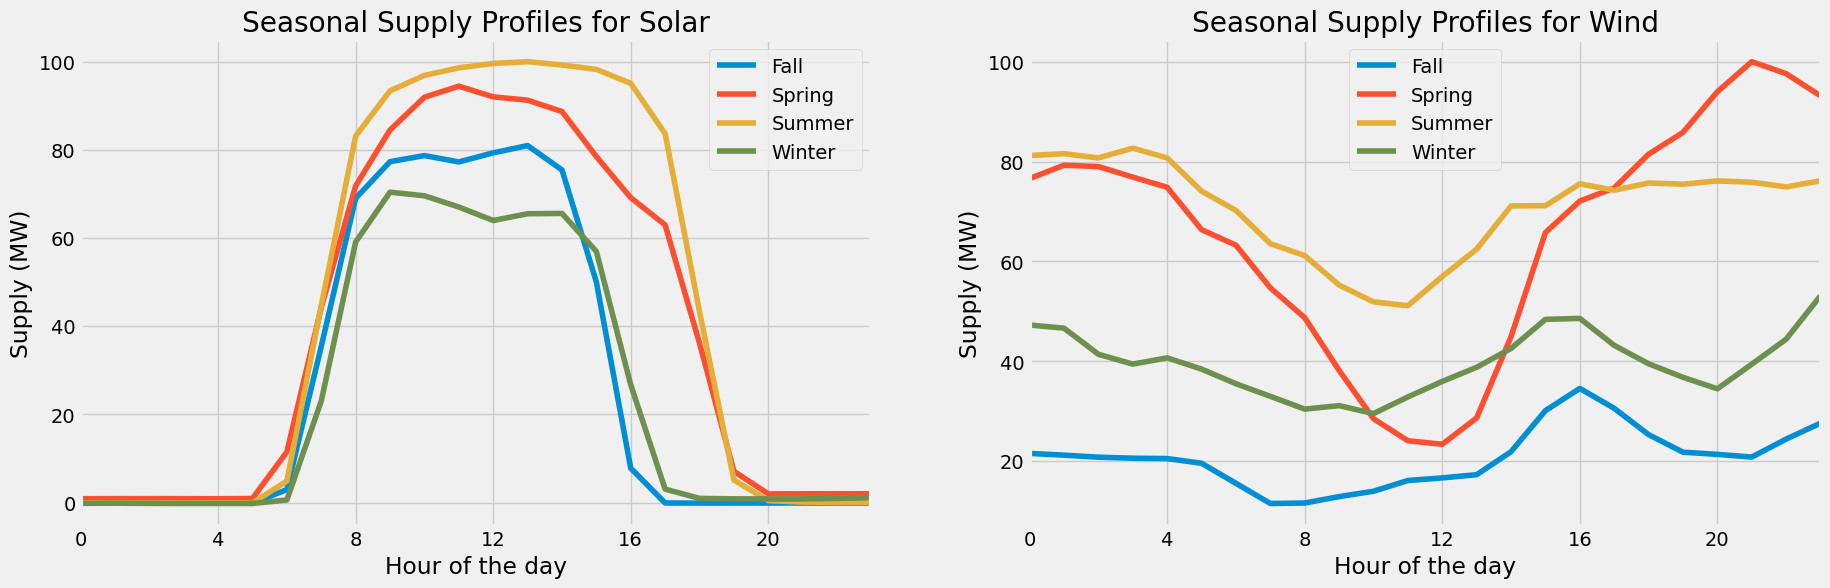

In [49]:
plot_seasonal_supply()

# 8 Export Current Set of Plants

In [50]:
"""
Examples of how to get widget state
# Get acitve incumbent plants
active_plants = get_active_plants(PORTFOLIO_TO_PLANTBUTTON_LOOKUP, verbose=VERBOSE)
# Get new plants to be invested in
new_plants = get_new_plants(NEW_PLANT_GRID)
# Get carbon price
carbon_price = carbon_price_box.value
# Update the fleet of acitve and new plants
fleet = get_fleet_portfolio(active_plants, new_plants)
"""

def get_analysis_dir():
    # Get current working directory
    curr_dir = Path.cwd()
    
    # Walk up until we find EEP-147* folder
    while not curr_dir.stem.startswith('EEP-147'):
        parent = curr_dir.parent
        if parent == curr_dir: # Hit root without finding EEP-147*
            raise Exception("Could not find EEP-147* folder in directory tree")
        curr_dir = parent
        
    # Found EEP-147* root, now get ESG-Analysis subfolder
    out_dir = curr_dir / 'ESG-Analysis'
    
    return out_dir



# Export current widget selections to CSV with auto-incrementing filename
def get_next_file_number(dir):
    i = 1
    while (dir / f'widget_selections_{i}.csv').exists():
        i += 1
    return i


def get_output_path():
    """Returns the path to the ESG-Analysis folder containing this notebook.
    
    Walks up directory tree until finding EEP-147* root folder, then returns path to 
    ESG-Analysis subfolder with given filename.
    """
    out_dir = get_analysis_dir()
    
    # Get next available file number
    file_num = get_next_file_number(out_dir)
    
    # Export with incremented filename
    filepath = out_dir / f'widget_selections_{file_num}.csv'
    
    # Return full path with filename
    return filepath



def export_widget_state():
    # Get active incumbent plants
    active_plants = get_active_plants(PORTFOLIO_TO_PLANTBUTTON_LOOKUP, verbose=VERBOSE)
    # Get new plants to be invested in 
    new_plants = get_new_plants(NEW_PLANT_GRID)
    # Update the fleet of active and new plants
    fleet = get_fleet_portfolio(active_plants, new_plants)
    
    filepath = get_output_path()
    
    # Save to CSV file
    fleet.to_csv(filepath, index=False)
    print(f"Exported current selections to {filepath}")

# Add export button
from ipywidgets import Button
export_button = Button(
    description='Export Selections',
    button_style='info'
)
export_button.on_click(lambda b: export_widget_state())
display(export_button)



Button(button_style='info', description='Export Selections', style=ButtonStyle())

# 9 Generate plot of outcomes

In [54]:
from tqdm.notebook import tqdm


# Get all exported scenario files
out_dir = get_analysis_dir()
scenario_files = out_dir.glob('widget_selections_*.csv')


def get_hours_demand_not_met(demand_not_met):
    hours = 0
    for hour in demand_not_met:
        hours += DAYS_IN_SEASON[hour[0]]
    return hours
        

# Run all scenarios
outcomes = []
# Show progress bar for processing scenarios
for scenario in tqdm(list(scenario_files), desc="Processing scenarios"):
    fleet = pd.read_csv(scenario)
    # Run scenario (plant types to subtract does not matter for market clearing)
    df_cleared, prices, capacity_payments, demand_not_met, markets = clear_market_all_hours(fleet=fleet, plant_types_to_subtract=[])
    outcomes.append(dict(
        costs = calc_total_costs(df_cleared, capacity_payments),
        hours_not_met = get_hours_demand_not_met(demand_not_met),
        emissions = calc_total_emissions(df_cleared),
    ))
outcomes = pd.DataFrame(outcomes)
outcomes

Processing scenarios:   0%|          | 0/7 [00:00<?, ?it/s]

,costs,hours_not_met,emissions
0,4.081122e+11,0,91939.619678
1,4.913727e+11,0,118587.880746
2,4.977479e+11,0,118587.880746
3,4.977479e+11,0,118587.880746
4,4.081122e+11,0,91939.619678
5,3.276734e+11,0,206221.183678
6,8.636407e+10,940,408117.832843
